In [1]:
# py27 compatability
from __future__ import print_function
from __future__ import division
# load packages
import numpy as np                                          # advanced array functions
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # plotting
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
# configure matplotlib
%matplotlib inline
import seaborn as sns                                       # statistics/ plotting
sns.set(style="ticks", font_scale=1.25)
from tqdm import tqdm_notebook                              # progress bar
import sspals
from mc_positronium import *

## Ps conversion

In [2]:
# simulate Ps converter
sim_600 = Ps_converter(1e5, T=600)
sim_1800 = Ps_converter(1e5, T=1800)

## Laser Interaction

In [3]:
laser = Laser(wavelength=243.0e-9, trigger=1.5e-8, height=0.008)
lyman_a = Spectroscopy(lambda_0=243.0e-9, linewidth=1.0/(2*np.pi*3.2e-9))

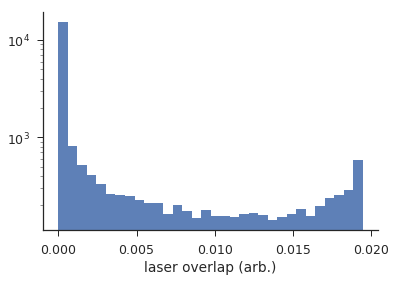

In [4]:
fig, ax = plt.subplots(figsize=(6, 4))
ol = lyman_a.overlap(sim_600, laser)
ol.hist(bins=32, ax=ax, alpha=0.9)

# format
ax.set_xlabel('laser overlap (arb.)')
ax.set_yscale('log')
ax.grid(False)
sns.despine()
plt.show()

In [5]:
# excitation threshold
ol_threshold = 0.001

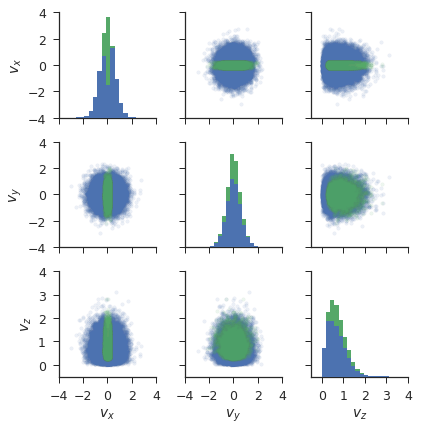

In [6]:
# find which Ps are excited by the laser
tmp = sim_600.copy()
tmp['excited'] = (ol > ol_threshold)
atoms = tmp[tmp.status == 'oPs'].copy()
# velocity distribution [(1e5) m s^-1]
atoms[['$v_x$', '$v_y$', '$v_z$']] = atoms[['vx', 'vy', 'vz']] *1e-5
g = sns.PairGrid(atoms, vars=['$v_x$', '$v_y$', '$v_z$'], hue='excited')
g = g.map_diag(plt.hist, bins=16, rwidth=1, lw=0.2)
g = g.map_offdiag(plt.scatter, alpha=0.1, marker='.', rasterized=True)

# format
g.fig.set_size_inches((6, 6))
g.axes[0][0].set_xlim((-4., 4.))
g.axes[0][0].set_xticks([-4, -2, 0, 2, 4])
g.axes[0][1].set_xlim((-4., 4.))
g.axes[0][1].set_xticks([-4, -2, 0, 2, 4])
g.axes[0][2].set_xlim((-0.5, 4.))
g.axes[0][2].set_xticks([0, 1, 2, 3, 4])
g.axes[0][0].set_ylim((-4., 4.))
g.axes[0][0].set_yticks([-4, -2, 0, 2, 4])
g.axes[1][0].set_ylim((-4., 4.))
g.axes[1][0].set_yticks([-4, -2, 0, 2, 4])
g.axes[2][0].set_ylim((-0.5, 4.))
g.axes[2][0].set_yticks([0, 1, 2, 3, 4])

#output
plt.savefig("../images/mc_vel.pdf", dpi=200, bbox_inches='tight')
plt.show()

In [7]:
# SSPALS spectrum
laser_off = sim_600['time of death']
laser_on = lyman_a.photoionize(sim_600, laser, ol_threshold)['time of death']
# convolve
dt = 1e-9
bins = np.arange(-5e-8, 8e-7, dt)
pwo = detector(np.arange(-1e-8, 2e-7, dt), 1e-8)
lt_off = np.histogram(laser_off.values, bins=bins, density=False)[0]
spectra_off = np.convolve(lt_off, pwo)
lt_on = np.histogram(laser_on.values, bins=bins, density=False)[0]
spectra_on = np.convolve(lt_on, pwo)

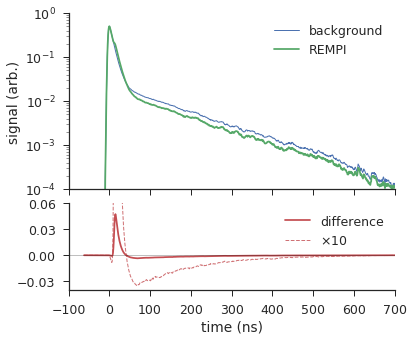

In [8]:
# plot setup
fig, ax = plt.subplots(figsize=(6,5))

# background subtraction subplot
divider = make_axes_locatable(ax)
axx = divider.append_axes("bottom", size=1.2, pad=0.2, sharex=ax)

# background
x_vals = np.arange(len(spectra_on)) * dt
rescale_on =  0.5*spectra_on / max(spectra_on)
rescale_off = 0.5*spectra_off / max(spectra_on)
ax.plot(x_vals * 1e9 - 62, rescale_off, lw=1, label='background')
# signal
ax.plot(x_vals * 1e9 -62, rescale_on, label='REMPI')
axx.plot(x_vals * 1e9 -62, rescale_on - rescale_off, c=sns.color_palette()[2], label='difference')
axx.plot(x_vals * 1e9 -62, 10*(rescale_on - rescale_off), c=sns.color_palette()[2], alpha = 0.8, lw=1, ls='--', label=r'$\times 10$')

#format
ax.legend()
axx.legend()
ax.set_yscale('log')
ax.set_ylabel("signal (arb.)")
axx.set_xlabel("time (ns)")
ax.set_ylim(1e-4, 1)
ax.set_xlim(-100, 700)
sns.despine()
plt.setp(ax.get_xticklabels(), visible=False)
axx.set_ylim([-0.04, 0.06])
axx.set_yticks([-0.03, 0, 0.03, 0.06])
axx.axhline(0, color='k', lw=0.5, alpha=0.5)

#output
plt.tight_layout()
plt.savefig("../images/mc_ion.pdf", dpi=200, bbox_inches='tight')
plt.show()

In [9]:
lyman_a.frac(sim_600, laser, ol_threshold)

0.23822085684709654

## delay scan and Doppler scan

In [10]:
#delay
trig_vals = np.arange(-1e-8, 1.5e-7, 1e-9)
sims = [sim_600, sim_1800]
fracs_t = []
for sim in tqdm_notebook(sims, desc='sim'):
    for trig in tqdm_notebook(trig_vals, desc='delay', leave=False):
        lz = Laser(wavelength=243.0e-9, trigger=trig)
        # find fraction excited by laser
        fracs_t.append(lyman_a.frac(sim, lz, ol_threshold))
fracs_t = np.array(fracs_t).reshape((-1, len(trig_vals)))

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [11]:
limits = [-1.0E-8, 3.5e-8, 7e-7] # cfd triggers on leading edge, around 5ns before positrons arrive
# background
spectra_off = spectra_off / max(spectra_off)
fb = sspals.sspals_1D(spectra_off, dt, limits=limits)['DF'][0]
# REMPI signal
S_t = []
trig_vals2 = np.arange(-1e-8, 1.5e-7, 5e-9)
for sim in tqdm_notebook(sims, desc='sim', leave=False):
    for trig in tqdm_notebook(trig_vals2, desc='delay', leave=False):
        lz = Laser(wavelength=243.0e-9, trigger=trig)
        laser_on = lyman_a.photoionize(sim, lz, ol_threshold)['time of death']
        lt = np.histogram(laser_on.values, bins=bins, density=False)[0]
        ## sspals spectrum
        spectra_on = np.convolve(lt, pwo)
        spectra_on = spectra_on / max(spectra_on)
        ## delayed fraction
        fd = sspals.sspals_1D(spectra_on, dt, limits=limits)['DF'][0]
        ## background subtraction
        S = sspals.signal(fd, 0, fb, 0)[0]
        S_t.append(S)
S_t = np.array(S_t).reshape((-1, len(trig_vals2)))

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [12]:
# wavelength
wav_vals = np.arange(2.427e-7, 2.433e-7, 5e-12)
fracs_w = []
for sim in tqdm_notebook(sims, desc='sim'):
    for wav in tqdm_notebook(wav_vals, desc='wavelength', leave=False):
        lz = Laser(wavelength=wav, trigger=1.5e-8)
        fracs_w.append(lyman_a.frac(sim, lz, ol_threshold))
fracs_w = np.array(fracs_w).reshape((-1, len(wav_vals)))

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [13]:
S_w = []
wav_vals2 = np.arange(2.427e-7, 2.433e-7, 2e-11)
for sim in tqdm_notebook(sims, desc='sim'):
    for wav in tqdm_notebook(wav_vals2, desc='wavelength', leave=False):
        lz = Laser(wavelength=wav, trigger=1.5e-8)
        laser_on = lyman_a.photoionize(sim, lz, ol_threshold)['time of death']
        lt = np.histogram(laser_on.values, bins=bins, density=False)[0]
        ## sspals spectrum
        spectra_on = np.convolve(lt, pwo)
        spectra_on = spectra_on / max(spectra_on)
        ## delayed fraction
        fd = sspals.sspals_1D(spectra_on, dt, limits=limits)['DF'][0]
        ## background subtraction
        S = sspals.signal(fd, 0, fb, 0)[0]
        S_w.append(S)
S_w = np.array(S_w).reshape((-1, len(wav_vals2)))

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

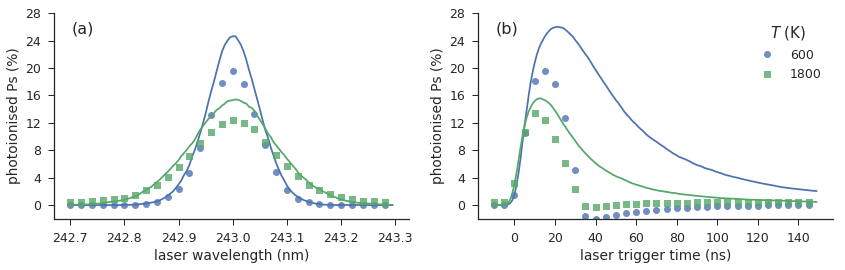

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
markers = ['o', 's']
lbls = ['600', '1800']
# delay
for i, fracs in enumerate(fracs_t):
    line = ax[1].plot(trig_vals *1e9, fracs * 100)
    ax[1].plot(trig_vals2 *1e9, S_t[i], '.', c=line[0].get_color(), marker=markers[i], alpha=0.8, label=lbls[i])
ax[1].set_xlabel('laser trigger time (ns)')
ax[1].set_ylabel(r'photoionised Ps (%)')

# wavelength
for i, fracs in enumerate(fracs_w):
    line = ax[0].plot(wav_vals *1e9, fracs * 100.0)
    ax[0].plot(wav_vals2 *1e9, S_w[i], '.', c=line[0].get_color(), marker=markers[i], alpha=0.8, label=lbls[i])
ax[0].set_xlabel('laser wavelength (nm)')
ax[0].set_ylabel(r'photoionised Ps (%)')
ax[1].legend(title='$T$ (K)')

# format
x_formatter = ScalarFormatter(useOffset=False)
ax[0].xaxis.set_major_formatter(x_formatter)
ax[0].annotate('(a)', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=16)
ax[1].annotate('(b)', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=16)
ax[1].set_yticks([0, 4, 8, 12, 16, 20, 24, 28])
ax[1].set_ylim(-2, 28)
ax[0].set_yticks([0, 4, 8, 12, 16, 20, 24, 28])
ax[0].set_ylim(-2, 28)
sns.despine()

#output
plt.tight_layout()
plt.savefig("../images/mc_delay_doppler.pdf", dpi=200, bbox_inches='tight')
plt.show()